# Exploratory Data Analysis

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re

In [74]:
raw_df = pd.read_csv('data/raw_case_data.csv', sep=';')

/var/folders/f_/vxvtgwts6mz_tts3y7tn115r0000gn/T/ipykernel_73002/334448432.py:1: DtypeWarning: Columns (64,65,80,83,84,85,86,87,88,91,94,95,96,97,98,99,102,105,106,107,108,109,110,111,112,113,114,115,120,123,124,125,126,127,128,129,130,131,134,135,136,137,205,206,207,210,211,212,213,214,215,216,217,218,219,220,221,224,231,234,235,236,237,238,239,240,241,242,245,246,249,250,251,254,255,256,259,260,261,262,269,270,271,272,273,274,275,276,277,278,279,280,281,282,301,302,303,304,305,306,307,308,309,310,313,314,315,318,319,320,322,323,324,325) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_df = pd.read_csv('data/raw_case_data.csv', sep=';')


In [54]:
# Display basic information about the DataFrame
print("Data Overview:")
# print(df.head())  # Display the first few rows
print(raw_df.info())  # Display data types and non-null counts
print(raw_df.describe())  # Display summary statistics

# Check for missing values
print("\nMissing Values:")
print(raw_df.isnull().sum())

# Explore unique values in categorical columns
print("\nUnique Values in Categorical Columns:")
for column in raw_df.select_dtypes(include=['object']).columns:
    print(f"{column}: {raw_df[column].unique()}")

Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178378 entries, 0 to 178377
Columns: 405 entries, Year of Aircraft Start Ts to Pushback Speed Max
dtypes: bool(2), float64(247), int64(1), object(155)
memory usage: 548.8+ MB
None
       Year of Aircraft Start Ts  A Acars Init Time  A Actual Deicing Time  \
count                   178378.0                0.0                    0.0   
mean                      2022.0                NaN                    NaN   
std                          0.0                NaN                    NaN   
min                       2022.0                NaN                    NaN   
25%                       2022.0                NaN                    NaN   
50%                       2022.0                NaN                    NaN   
75%                       2022.0                NaN                    NaN   
max                       2022.0                NaN                    NaN   

       A Actual Off Block Time  A Actual Take Off Ti

Many columns are empty, so I will drop them

In [75]:
# finding columns that are only missing values
nan_mask = raw_df.isnull().sum() == 178378
nan_columns = [raw_df.columns[nan_mask]]

# dropping them from the dataset and saving the results
df = raw_df.drop(columns=raw_df.columns[nan_mask], inplace=False)
df.to_csv("data/case_data.csv", index=False, sep=';')

Some basic viz on the remaining numerical columns


Distribution of Numerical Features:


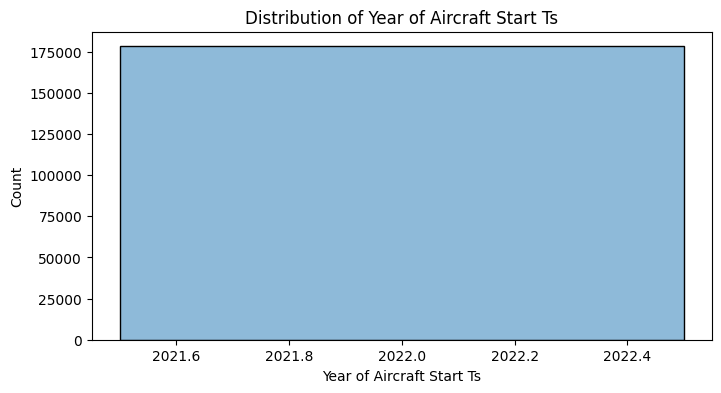

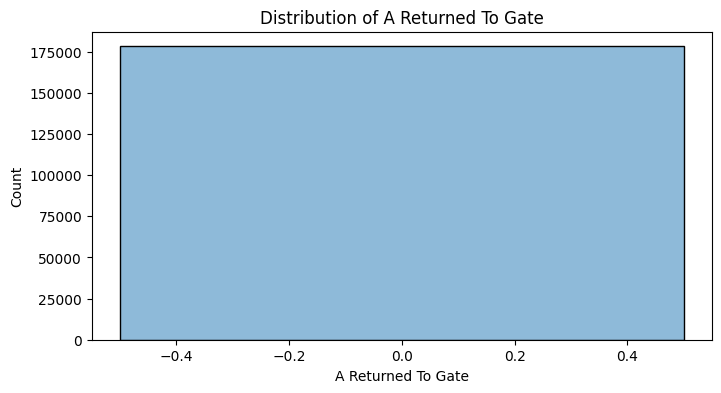

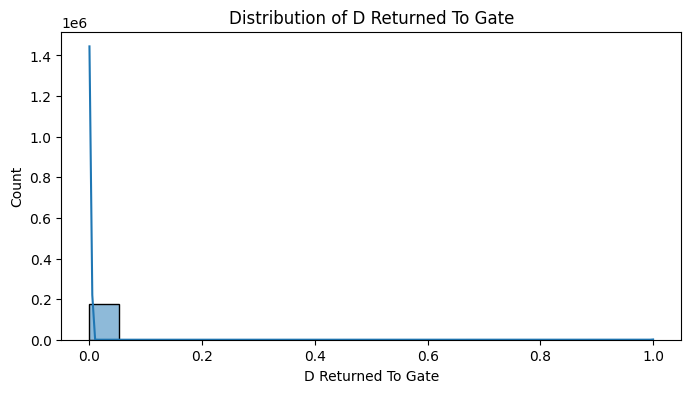

In [48]:
# Visualize the distribution of numerical features
print("\nDistribution of Numerical Features:")
for column in df.select_dtypes(exclude=['object']).columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.show()


Pairwise Relationships:


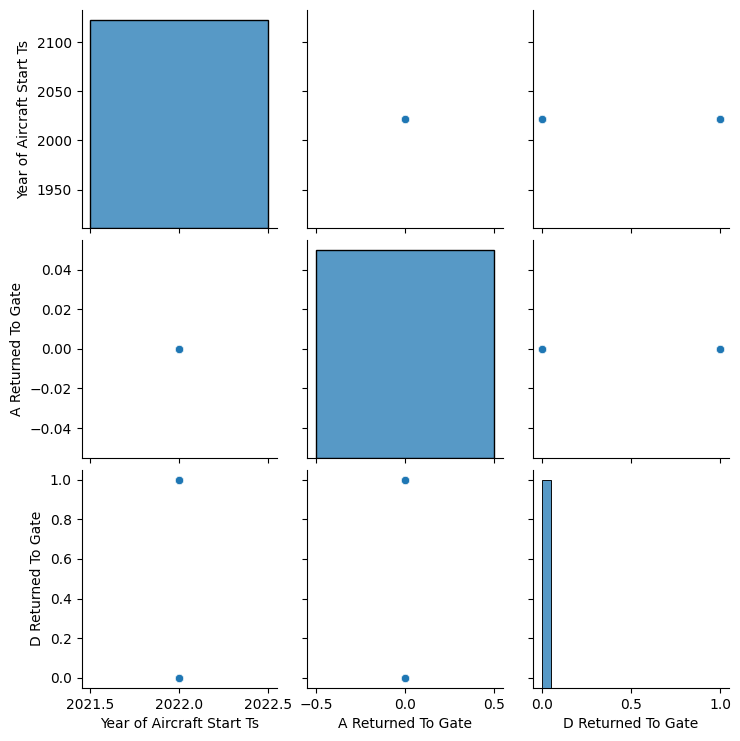

In [51]:
# Visualize relationships between variables
print("\nPairwise Relationships:")
sns.pairplot(df)
plt.show()

The departures that had to return to the gate are interesting

In [59]:
d_returns = df[df['D Returned To Gate'] == True]

Let's find safety issues

 IDEA: FIND WHERE CATERING END OR FUEL END IS TOO CLOSE TO PREDICTED TAKEOFF TIME

In [79]:
no_vest = df[df['Human Without Vest Start Ts'].notnull()]

In [78]:
no_vest.shape

(2939, 158)

In [62]:
# RETURNS NONETYPE
# Function to check if a value matches the specified date format
def is_valid_date(value):
    date_pattern = re.compile(r'^\d{2}-\d{2}-\d{4}$')
    return bool(re.match(date_pattern, str(value)))

# Identify columns with entries that are in the specified date format
date_columns = [col for col in df.columns if any(df[col].head(50).apply(lambda x: is_valid_date(x)))]
date_columns

# Convert identified columns to datetime
# no_dates_df = df[df.columns != date_columns]

# Display the DataFrame after converting columns to datetime
# no_dates_df

[]